In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

import random
import shutil

import keras.backend as K
K.set_image_data_format('channels_last')

from matplotlib.pyplot import imshow
from keras.preprocessing import image
import tensorflow as tf
from keras import applications
from keras.models import Sequential
import os,sys
import warnings
warnings.simplefilter("ignore")
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
import cv2
from keras.preprocessing.image import ImageDataGenerator

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:

dataset_path = "../Dog_Breed_Dataset/Dog_60subset"
data_dir = '../Dog_Breed_Dataset/Dog_60subset'
train_path = "../photos/Dog_Breed_Dataset/train"
test_path = "../photos/Dog_Breed_Dataset/test"
val_path = "../photos/Dog_Breed_Dataset/val"



In [51]:
import os

def count_images_in_folder(folder_path):
    # Get a list of subfolders (categories) in the main folder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    # Dictionary to store the count of images for each subfolder
    image_counts = {}

    # Iterate through each subfolder
    for subfolder in subfolders:
        # Count the number of files (images) in the subfolder
        image_count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
        
        # Store the count in the dictionary with the subfolder name as the key
        subfolder_name = os.path.basename(subfolder)
        image_counts[subfolder_name] = image_count

    return image_counts

# Example usage:
folder_path = data_dir
result = count_images_in_folder(folder_path)

# Display the result
for category, count in result.items():
    print(f"Category: {category}, Number of Images: {count}")


Category: affenpinscher, Number of Images: 350
Category: Afghan_hound, Number of Images: 461
Category: African_hunting_dog, Number of Images: 380
Category: Airedale, Number of Images: 402
Category: American_Staffordshire_terrier, Number of Images: 380
Category: Appenzeller, Number of Images: 385
Category: Australian_Shepherd, Number of Images: 245
Category: Australian_terrier, Number of Images: 398
Category: basenji, Number of Images: 452
Category: basset, Number of Images: 416
Category: beagle, Number of Images: 471
Category: Bedlington_terrier, Number of Images: 396
Category: Bernese_mountain_dog, Number of Images: 429
Category: Bichon_Frise, Number of Images: 506
Category: black_and_tan_coonhound, Number of Images: 384
Category: Black_sable, Number of Images: 258
Category: Blenheim_spaniel, Number of Images: 395
Category: bloodhound, Number of Images: 394
Category: bluetick, Number of Images: 388
Category: Border_collie, Number of Images: 490
Category: Border_terrier, Number of Imag

In [52]:
img_height = img_width = 229
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

class_names = train_ds.class_names

Found 22635 files belonging to 59 classes.
Using 18108 files for training.
Found 22635 files belonging to 59 classes.
Using 4527 files for validation.


In [ ]:
# datagen_train = ImageDataGenerator( 
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest',
#         preprocessing_function=applications.xception.preprocess_input)
# 
# datagen_val = ImageDataGenerator( 
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest',
#         preprocessing_function=applications.xception.preprocess_input)
# 
# datagen_test=ImageDataGenerator( 
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest',
#         preprocessing_function=applications.xception.preprocess_input)
# 
# train_generator = datagen_train.flow_from_directory(
#     directory=train_path,
#     target_size=(299, 299),
#     color_mode="rgb",
#     batch_size=64,
#     class_mode="categorical",
#     shuffle=True,
#     seed=42, 
#     subset="training"
# )
# 
# # Valid generator
# valid_generator = datagen_val.flow_from_directory(
#     directory=val_path,
#     target_size=(299, 299),
#     color_mode="rgb",
#     batch_size=64,
#     class_mode="categorical",
#     shuffle=True,
#     seed=42
# )
# 
# # Test generator
# test_generator = datagen_test.flow_from_directory(
#     directory=test_path,
#     target_size=(299, 299),
#     color_mode="rgb",
#     batch_size=64,
#     class_mode="categorical",
#     shuffle=False,
#     seed=42
# )
# # get list of class names
# class_names = list(train_generator.class_indices.keys())


In [53]:
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

optimizer = optimizers.Adam(lr=0.0001)
learning_rate_reduction = ReduceLROnPlateau(monitor='sparse_categorical_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [54]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
from keras.applications.xception import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(229, 229, 3))


x = base_model.output
x = tf.keras.applications.xception.preprocess_input(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(60, activation='softmax')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False
    
# this is the model we will train
xception = Model(inputs=base_model.input, outputs=predictions)

xception.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])


In [56]:
xception.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    verbose=1,
                    callbacks=[learning_rate_reduction])

Epoch 1/20
283/283 [==============================] - 61s 203ms/step - loss: 4.1055 - sparse_categorical_accuracy: 0.0310 - sparse_top_k_categorical_accuracy: 0.1290 - val_loss: 4.0241 - val_sparse_categorical_accuracy: 0.0366 - val_sparse_top_k_categorical_accuracy: 0.1440 - lr: 1.0000e-04
Epoch 2/20
283/283 [==============================] - 75s 265ms/step - loss: 3.9563 - sparse_categorical_accuracy: 0.0514 - sparse_top_k_categorical_accuracy: 0.1872 - val_loss: 3.8636 - val_sparse_categorical_accuracy: 0.0746 - val_sparse_top_k_categorical_accuracy: 0.2352 - lr: 1.0000e-04
Epoch 3/20
283/283 [==============================] - 83s 294ms/step - loss: 3.8854 - sparse_categorical_accuracy: 0.0619 - sparse_top_k_categorical_accuracy: 0.2157 - val_loss: 3.7753 - val_sparse_categorical_accuracy: 0.0925 - val_sparse_top_k_categorical_accuracy: 0.2721 - lr: 1.0000e-04
Epoch 4/20
283/283 [==============================] - 71s 249ms/step - loss: 3.8266 - sparse_categorical_accuracy: 0.0702 - 

In [57]:
loss, sparse_cat_acc, sparse_top_k_cat_acc = xception.evaluate(test_ds, verbose=1) # add topk

14/14 [==============================] - 2s 85ms/step - loss: 3.3883 - sparse_categorical_accuracy: 0.1629 - sparse_top_k_categorical_accuracy: 0.3973


In [58]:
# save model and architecture to single file
xception.save("xception_60dogs_evenclasses.h5")

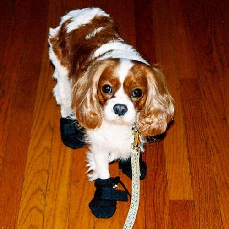

In [59]:
img = tf.keras.preprocessing.image.load_img('../Dog_Breed_Dataset/Dog_60subset/Blenheim_spaniel/n110771.jpg', target_size=(229, 229))
img_array = tf.keras.preprocessing.image.img_to_array(img)/255
# img_array = tf.keras.applications.xception.preprocess_input(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = np.array([img_array]) 
img

In [60]:
# generate predictions for samples
predictions = xception.predict(img_array)

# generate argmax for predictions
# class_id = np.argmax(predictions, axis = 1)

# get top 10 predictions
print(predictions[0])
top_10_predictions = np.argsort(predictions[0])[:-11:-1]

# top 10 predictions
for i in range(10):
    print(class_names[top_10_predictions[i]])

1/1 [==============================] - 1s 714ms/step
[1.9394e-02 1.1246e-02 6.7749e-02 1.3977e-02 3.0403e-03 2.5043e-03
 1.8005e-02 2.8442e-02 6.2790e-03 1.6022e-03 6.5346e-03 5.4817e-03
 4.8904e-03 3.4821e-02 9.6283e-03 6.6338e-03 2.0157e-02 1.4465e-02
 5.0011e-03 3.2539e-03 4.0070e-02 1.5450e-02 2.8229e-03 4.9973e-03
 3.9276e-02 1.9970e-03 3.8177e-02 1.1940e-02 4.9515e-03 5.9319e-03
 8.4610e-03 8.1329e-03 8.5373e-03 3.8269e-02 2.9802e-07 1.5915e-02
 1.7654e-02 2.0126e-02 1.7868e-02 1.4442e-02 1.5930e-02 1.4496e-02
 3.8849e-02 9.5520e-03 2.8275e-02 1.9272e-02 2.2919e-02 1.4137e-02
 7.0068e-02 1.3702e-02 1.3023e-02 4.8920e-02 5.0735e-03 6.4392e-03
 2.6321e-02 3.3295e-02 5.9929e-03 4.9591e-03 1.0574e-02 4.1723e-07]
cairn
Airedale
cocker_spaniel
Chesapeake_Bay_retriever
Doberman
bloodhound
German_short-haired_pointer
English_setter
Border_terrier
dingo
